CNN for Fake News classification

# Importing general usage tools

In [0]:
pip install tqdm --upgrade

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.43.0)


In [0]:
from keras.models import Sequential
from keras import layers
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import numpy as np

Using TensorFlow backend.


# Hyperparameter Adjustment

In [0]:
# parameter adjustments for fake news
maxlen = 100
embedding_dim = 300
max_features = 50000
train_glove = True   # Turn on/off for trainnable glove

# Reading in the dataset

In [0]:
# Reading files
import re
train = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/train.csv")
valid = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/valid.csv")
test = pd.read_csv("/content/drive/My Drive/cmpt400/dataset/test.csv")

# train['news'] = train['news'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
# valid['news'] = valid['news'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
# test['news'] = test['news'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))

print("Train shape : ",train.shape)
print("Valid shape : ",valid.shape)
print("Test shape : ",test.shape)


Train shape :  (10240, 2)
Valid shape :  (1284, 2)
Test shape :  (1267, 2)


In [0]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

# Data Preprocessing Helper function

##Text punct cleaning

In [0]:
import re
def clean_text(x):
  x = str(x)
  for punct in "/-":
      x = x.replace(punct, ' ')
  for punct in '&':
      x = x.replace(punct, f' {punct} ')
  for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
      x = x.replace(punct, '')
  return x


##Number cleaning

In [0]:
def clean_numbers(x):
  x = re.sub('[0-9]{5,}', '#####', x)
  x = re.sub('[0-9]{4}', '####', x)
  x = re.sub('[0-9]{3}', '###', x)
  x = re.sub('[0-9]{2}', '##', x)
  return x

##Mis-spelling cleaning

In [0]:
mispell_dict =  {'colour':'color',
          'centre':'center',
          'didnt':'did not',
          'doesnt':'does not',
          'isnt':'is not',
          'shouldnt':'should not',
          'favourite':'favorite',
          'travelling':'traveling',
          'counselling':'counseling',
          'theatre':'theater',
          'cancelled':'canceled',
          'labour':'labor',
          'organisation':'organization',
          'wwii':'world war 2',
          'citicise':'criticize',
          'instagram': 'social medium',
          'whatsapp': 'social medium',
          'snapchat': 'social medium'
          }

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

##Check for vocabulary coverage 

In [0]:
import operator 

# i: oov_word_count
# k: covered_word_count 
def check_coverage(vocab,embeddings_index):
  a = {}
  oov = {}
  covered_word_count = 0
  oov_word_count = 0
  for word in tqdm(vocab):
      try:
          a[word] = embeddings_index[word]
          covered_word_count += vocab[word]
      except:

          oov[word] = vocab[word]
          oov_word_count += vocab[word]
          pass
  print()
  print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
  print('Found embeddings for  {:.2%} of all text'.format(covered_word_count / (covered_word_count + oov_word_count)))
  sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

  return sorted_x


# Loading glove

In [0]:
#created the glove matrix
from gensim.models import KeyedVectors
filepath_news = '/content/drive/My Drive/cmpt400/dataset/GoogleNews-vectors-negative300.bin'
filepath_6b = '/content/drive/My Drive/cmpt400/dataset/glove.6B.50d.txt'
embeddings_index = KeyedVectors.load_word2vec_format(filepath_news, binary=True)
print(embeddings_index)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


##Preprocess all in one

In [0]:
def preprocess(dataset):
  dataset = dataset.progress_apply(lambda x: clean_text(x))
  dataset = dataset.progress_apply(lambda x: clean_numbers(x))
  dataset = dataset.progress_apply(lambda x: replace_typical_misspell(x))
  dataset = dataset.progress_apply(lambda x: x.split()).values
  to_remove = ['a','to','of','and']
  dataset = [[word for word in sentence if not word in to_remove] for sentence in tqdm(dataset)]
  
  return dataset

##Call all preprocess function to clean up the dataset

In [0]:
train['news'] = preprocess(train['news'])
valid['news'] = preprocess(valid['news'])
test['news'] = preprocess(test['news'])

100%|██████████| 1267/1267 [00:00<00:00, 300321.17it/s]


Store word occurence as dictionary for quick coverage check

In [0]:
vocab_train = build_vocab(train['news'])
vocab_valid = build_vocab(valid['news'])
vocab_test = build_vocab(test['news'])
print()
# print({k: vocab[k] for k in list(vocab)[:10]})

100%|██████████| 1267/1267 [00:00<00:00, 161167.72it/s]

## Coverage Result

In [0]:
# check for vocab coverage
oov = check_coverage(vocab_train,embeddings_index)
print()
oov = check_coverage(vocab_valid,embeddings_index)
print()
oov = check_coverage(vocab_test,embeddings_index)
print()

100%|██████████| 4555/4555 [00:00<00:00, 427760.22it/s]


Found embeddings for 96.05% of vocab
Found embeddings for  99.61% of all text


Found embeddings for 98.23% of vocab
Found embeddings for  99.59% of all text


Found embeddings for 98.11% of vocab
Found embeddings for  99.53% of all text



## Build Embadding Matrix Helper Function

In [0]:
def build_matrix(word_index, embedding_index):
  vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
  # calculate how many word will be used
  num_words = min(max_features,vocab_size)

  embedding_matrix = np.zeros((num_words, embedding_dim))
  unknown_words = []

  for word, i in word_index.items():
      if i <= max_features:
          try:
              embedding_matrix[i] = embedding_index[word]
          except KeyError:
              try:
                  embedding_matrix[i] = embedding_index[word.lower()]
              except KeyError:
                  try:
                      embedding_matrix[i] = embedding_index[word.title()]
                  except KeyError:
                      unknown_words.append(word)
  return embedding_matrix, unknown_words

# Tokenization

Initialize tokenizer

In [0]:
tokenizer = Tokenizer(num_words=max_features, filters='',lower=False)

In [0]:
# Tokenizer fitting
# print(list(train['news']))
tokenizer.fit_on_texts(list(train['news']) + list(valid['news']) + list(test['news']))

In [0]:
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index,embedding_index=embeddings_index)
print(unknown_words_glove)
print('dont' in embeddings_index)

['hasnt', '####json', 'wasnt', 'Kasichs', '#####json', 'Cruzs', '###json', 'Gingrichs', 'SaysPresident', 'Medicares', 'Mandels', 'Klux', 'SaysHillary', 'Marwig', 'TriMets', 'healthcaregov', 'H1N1', 'Parenthoods', 'crimecriminal', 'deficitfederal', 'Securitys', 'Rigells', 'unemployments', 'AbrahamLincoln', 'Zenzinger', 'OShaughnessy', 'Silberkraus', 'SaysBernie', 'donu####t', 'Marilinda', 'AmendmentBan', 'Jan1', 'therell', 'Medicaids', 'Obamacares', 'hewent', 'wasgovernor', 'Beachs', 'DonaldTrump', 'Renaccis', 'Amtraks', 'Ganleys', 'percentincrease', 'Kaines', 'Kloppenburgs', 'NAACPs', 'FreshFromFloridacom', 'Krakows', 'SaysMichael', 'prisonand', 'Alameel', 'shootershould', 'toldevery', 'fiscalcliff', '\u202aBernie\u202c', 'Krisemans', 'branchesof', 'SaysRand', 'Paulhas', 'subminimum', 'requirecondom', 'usein', 'riskfor', '##collecting', 'Republicancandidate', 'Aphotograph', 'Democraticcongressional', 'MorganCarroll', 'SaysPeter', 'SaysVirginia', 'RepublicanScott', 'averagein', 'yearThe

In [0]:
import keras
# tokenize text 
X_train = tokenizer.texts_to_sequences(train['news'])
X_valid = tokenizer.texts_to_sequences(valid['news'])
X_test = tokenizer.texts_to_sequences(test['news'])

# pad each news to maxlen
X_train = pad_sequences(X_train, maxlen=maxlen,padding='post',truncating='post')
X_valid = pad_sequences(X_valid, maxlen=maxlen,padding='post',truncating='post')
X_test = pad_sequences(X_test, maxlen=maxlen,padding='post',truncating='post')

y_label_dict = {"pants-fire" : 0, "false" : 1, "barely-true" : 2, "half-true" : 3, "mostly-true" : 4, "true" : 5}
print(y_label_dict)

# turn categories into integer representation
y_train = train['label'].apply(lambda x: y_label_dict[x])
y_valid = valid['label'].apply(lambda x: y_label_dict[x])
y_test = test['label'].apply(lambda x: y_label_dict[x])

y_train = keras.utils.to_categorical(y_train, num_classes=6)
y_valid = keras.utils.to_categorical(y_valid, num_classes=6)
y_test = keras.utils.to_categorical(y_test, num_classes=6)

#calculate the total vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

n_timesteps, n_features = X_train.shape[0], X_train.shape[1]
print(y_train[0])
print(y_test[1])

{'pants-fire': 0, 'false': 1, 'barely-true': 2, 'half-true': 3, 'mostly-true': 4, 'true': 5}
[0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0.]


# Plotting Graph Helper Function

In [0]:
# Plotting graph from results
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Attention Layer Construction

In [0]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

class Attention(Layer):
  def __init__(self, step_dim,
            W_regularizer=None, b_regularizer=None,
            W_constraint=None, b_constraint=None,
            bias=True, **kwargs):
    self.supports_masking = True
    self.init = initializers.get('glorot_uniform')
    '''
    Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
    These penalties are incorporated in the loss function that the network optimizes.
    '''
    self.W_regularizer = regularizers.get(W_regularizer)
    self.b_regularizer = regularizers.get(b_regularizer)

    self.W_constraint = constraints.get(W_constraint)
    self.b_constraint = constraints.get(b_constraint)

    self.bias = bias
    self.step_dim = step_dim
    self.features_dim = 0
    super(Attention, self).__init__(**kwargs)

  def build(self, input_shape):
    assert len(input_shape) == 3

    self.W = self.add_weight((input_shape[-1],),
                            initializer=self.init,
                            name='{}_W'.format(self.name),
                            regularizer=self.W_regularizer,
                            constraint=self.W_constraint)
    self.features_dim = input_shape[-1]

    if self.bias:
        self.b = self.add_weight((input_shape[1],),
                                initializer='zero',
                                name='{}_b'.format(self.name),
                                regularizer=self.b_regularizer,
                                constraint=self.b_constraint)
    else:
        self.b = None

    self.built = True

  def compute_mask(self, input, input_mask=None):
    return None

  def call(self, x, mask=None):
    features_dim = self.features_dim
    step_dim = self.step_dim

    eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                    K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

    if self.bias:
        eij += self.b

    eij = K.tanh(eij)

    a = K.exp(eij)

    if mask is not None:
        a *= K.cast(mask, K.floatx())

    a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

    a = K.expand_dims(a)
    weighted_input = x * a
    return K.sum(weighted_input, axis=1)

  def compute_output_shape(self, input_shape):
    return input_shape[0],  self.features_dim

# Creating Model


In [0]:
from keras.models import Sequential
from keras.models import Model
from keras import layers as L
from keras.optimizers import SGD,RMSprop,Adam
from keras.layers import Convolution2D, Dense, Flatten, LSTM, Bidirectional, Dropout, CuDNNLSTM, Lambda, dot, Activation, concatenate
from keras.losses import categorical_crossentropy
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ModelCheckpoint

## Model Function

In [0]:
# from keras.models import Sequential
# from keras import layers,optimizers
# from keras.optimizers import SGD,RMSprop,Adam
# from keras.layers import Convolution2D,Dense,MaxPooling1D,Flatten,LSTM,Bidirectional,Dropout,CuDNNLSTM
# from keras.losses import categorical_crossentropy
# from keras.losses import sparse_categorical_crossentropy
# from keras.callbacks import ModelCheckpoint

# train_glove = True
# sgd = SGD(lr=0.025, clipvalue=0.3, nesterov=True)
# adam = Adam(lr=0.000075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# model = Sequential()
# model.add(layers.Embedding(vocab_size, embedding_dim,weights=[glove_matrix], input_length=maxlen,trainable=train_glove))
# model.add(Dropout(0.8))
# # initialising the RNN
# # number of units-memory units, complex problem requir more nerons.
# # return sequence-mutiple LSM layers, set to True to receive values. Default value is False
# # dimensions-it takes in count of original dataset. This case only include timestep and indicators.

# # First LSTM layer
# model.add(Bidirectional(CuDNNLSTM(units = 75,return_sequences = True, input_shape=(n_timesteps,n_features))))
# # model.add(Dropout(0.4))

# # model.add(Bidirectional(CuDNNLSTM(units = 100,return_sequences = True)))
# # # model.add(Dropout(0.4))

# # Fourth LSTM layer, last layer no need to return, use default return sequence value false.
# model.add(Bidirectional(CuDNNLSTM(units = 75)))

# model.add(layers.Dense(64, activation='relu'))

# model.add(layers.Dense(32, activation='relu'))

# model.add(layers.Dense(6, activation='softmax'))

# # model.compile(optimizer=RMSprop(lr=0.001),loss=sparse_categorical_crossentropy,metrics=['accuracy'],)     # 0.001 seems to give the best output
# model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
# model.summary()

# cp=ModelCheckpoint('model_fake',monitor='acc',verbose=1, save_best_only=True, mode='max')

In [0]:
def attention_3d_block(hidden_states):
    # @author: felixhao28.
    # hidden_states.shape = (batch_size, time_steps, hidden_size)
    hidden_size = int(hidden_states.shape[2])
    # Inside dense layer
    #              hidden_states            dot               W            =>           score_first_part
    # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
    # W is the trainable weight matrix of attention Luong's multiplicative style score
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
    #            score_first_part           dot        last_hidden_state     => attention_weights
    # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

In [0]:
# calling this funciton to cerate a model
train_glove = True
sgd = SGD(lr=0.025, clipvalue=0.3, nesterov=True)
adam = Adam(lr=0.000075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

def build_model(verbose = True, compile = True):
  sequence_input = L.Input(shape=(maxlen,), dtype='int32')
  embedding_layer = L.Embedding(vocab_size,
                  embedding_dim,
                  weights=[glove_matrix],
                  input_length=maxlen,
                  trainable=train_glove)
  x = embedding_layer(sequence_input)
  x = L.Dropout(0.5)(x)

  # First LSTM layer
  x = Bidirectional(CuDNNLSTM(units = 100,return_sequences = True, input_shape=(n_timesteps,n_features)))(x)
  # LSTM layer, last layer no need to return, use default return sequence value false.
  x = Bidirectional(CuDNNLSTM(units = 100,return_sequences = True))(x)
  # Construct concat layers combine: attention globalavg,globalmax
  att = Attention(maxlen)(x)

  avg_pool1 = L.GlobalAveragePooling1D()(x)
  max_pool1 = L.GlobalMaxPooling1D()(x)

  x = L.concatenate([att, avg_pool1, max_pool1])
  # x = L.concatenate([avg_pool1, max_pool1])

  x = L.Dense(64, activation='relu')(x)

  x = L.Dense(32, activation='relu')(x)

  preds = L.Dense(6, activation='softmax')(x)

  model = Model(sequence_input, preds)
  if verbose:
    model.summary()
  if compile:
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
  return model

# Predicting


## Make Model

In [0]:
cp=ModelCheckpoint('model_fake',monitor='acc',verbose=1, save_best_only=True, mode='max')
model = build_model()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     4464900     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 200)     321600      d

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10240 samples, validate on 1284 samples
Epoch 1/10
10240/10240 [==============================] - 13s 1ms/step - loss: 1.7688 - acc: 0.1954 - val_loss: 1.7579 - val_acc: 0.2056

Epoch 00001: acc improved from -inf to 0.19541, saving model to model_fake
Epoch 2/10
10240/10240 [==============================] - 6s 574us/step - loss: 1.7537 - acc: 0.2144 - val_loss: 1.7510 - val_acc: 0.2383

Epoch 00002: acc improved from 0.19541 to 0.21436, saving model to model_fake
Epoch 3/10
10240/10240 [==============================] - 6s 575us/step - loss: 1.7457 - acc: 0.2347 - val_loss: 1.7387 - val_acc: 0.2360

Epoch 00003: acc improved from 0.21436 to 0.23467, saving model to model_fake
Epoch 4/10
10240/10240 [==============================] - 6s 576us/step - loss: 1.7292 - acc: 0.2437 - val_loss: 1.7209 - val_acc: 0.2547

Epoch 00004: acc improved from 0.23467 to 0.24375, saving model to mo

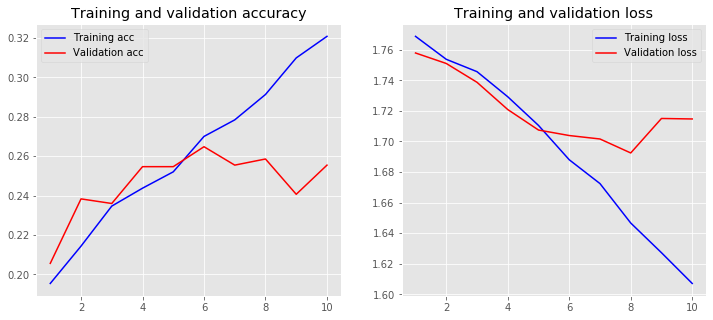

In [0]:
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_valid, y_valid),batch_size=64,callbacks=[cp])
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=2)
print("Valid Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)